<a href="https://colab.research.google.com/github/MitraDP/Surface_Defect_Detection/blob/master/SurfaceDefectDetection_MagneticTile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Surface Defect Detection of Magnetic Tile

##Install the NVIDIA System Management Interface

In [ ]:
!ls -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi
!nvcc --version

/opt/bin/nvidia-smi  /usr/bin/nvidia-smi
Sun Feb 28 05:45:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                               

##Download datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!wget -O data.zip https://github.com/abin24/Magnetic-tile-defect-datasets./archive/master.zip
!unzip data.zip

In [ ]:
!mv Magnetic-tile-defect-datasets.-master data

##Library imports and the environment setting

In [ ]:
%%capture
import numpy as np
import pandas as pd
              
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile, Image
#ImageFile.LOAD_TRUNCATED_IMAGES = True

!pip install torch
!pip install torchvision
!pip install torchsummary
import torch
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim

import os
from glob import glob
import random
from random import shuffle
from tqdm import tqdm

!pip install torch-lr-finder
from torch_lr_finder import LRFinder

In [ ]:
from transforms import Resize, Rotate, VerticalFlip, HorizontalFlip, Normalize, ToTensor
from dataset import SurfaceDefectDetectionDataset, partitioning
from loss import WeightedBCELoss, TverskyLoss
from unet import UNet_2D
from metrics import performance_metrics 
from train import train_2D
from inference import plot_prediction_results, get_inference_performance_metrics

In [ ]:
#check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available. Training on GPU ...')

CUDA is available. Training on GPU ...


In [ ]:
##Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(123)

##Set the parameters

In [ ]:
batch_size = 32    # batch_size for the train and validation set
test_batch_size =1 # batch_size for the test set
num_workers = 0
n_epochs = 200
optimizer_type = 'Adam' """Either Adam or SGD, adjust the learning rate in the
                           "Specify the loss function and optimizer" section"""
threshold = 0.5   # Threshold value to create binary image 
lr_find = False   # Set to True to find the maximum learning rate
criterion_type = 'TverskyLoss'  """ Adjust the penalties in the "Specify the loss 
                                  function and optimizer" section"""  
classes =['Blowhole', 'Crack','Free'] # classes/labels
split_ratio = [0.70, 0.10, 0.20]      # A list of the (train,val,test) split ratio

## Dataset

In [ ]:
partition = partitioning(split_ratio)

Blowhole _  train:  80   val:  11   test:  24   total:  115
Crack _  train:  39   val:  6   test:  12   total:  57
Free _  train:  56   val:  7   test:  17   total:  80


In [ ]:
# Construct the transformed dataset
surface_defect_dataset ={}
for p in ['train', 'val', 'test']:
    surface_defect_dataset[p] = SurfaceDefectDetectionDataset (partition[p], p)

### Visualize sample images along with their masks

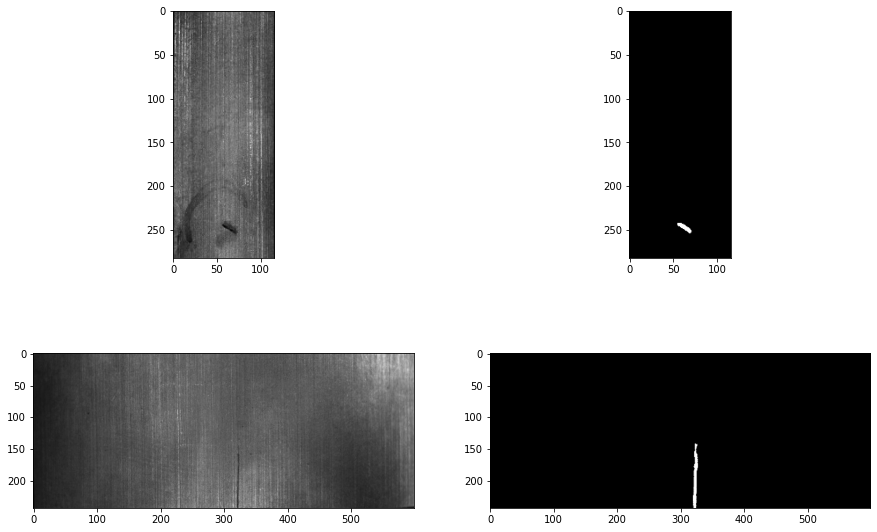

In [ ]:
images_path=['data/MT_Blowhole/Imgs/exp1_num_4944','data/MT_Crack/Imgs/exp1_num_86828']
#Define the size of images
fig =  plt.figure(figsize=(15, 10))
n=len(images_path)
for i, im_path in enumerate(images_path):
    ax = fig.add_subplot(n,2,2*i+1) 
    plt.imshow(Image.open(im_path+'.jpg'), cmap='gray')
    ax = fig.add_subplot(n,2, 2*i+2)
    plt.imshow(Image.open(im_path+'.png'), cmap='gray')

###Visualize transforms on sample images and masks


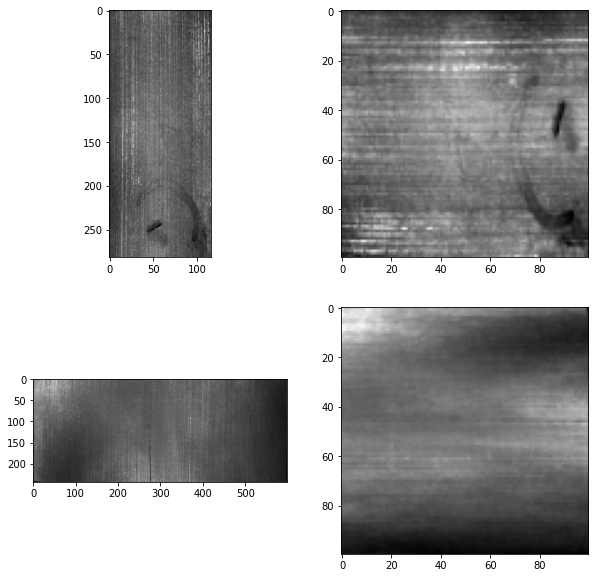

In [ ]:
images_path=['data/MT_Blowhole/Imgs/exp1_num_4944',
            'data/MT_Crack/Imgs/exp1_num_86828']
#Define the size of images
fig =  plt.figure(figsize=(10, 10))
n=len(images_path)
for i, im_path in enumerate(images_path):
    image = Image.open(images_path[i]+'.jpg')
    mask = Image.open(images_path[i]+'.png')
    t1 = HorizontalFlip()
    t2 = Resize((100,100))
    t3 = Rotate(90)
    ax1 = fig.add_subplot(n,2,2*i+1) 
    plt.imshow(t1(image), cmap='gray')  # Added by Ray
    ax2 = fig.add_subplot(n,2, 2*i+2)
    plt.imshow(t3(t2(image)), cmap='gray')


### Some stats about the dataset

In [ ]:
#fing the range of height and width of train images
H = []
W = []
pair = []
for p in partition['train']:
  image = Image.open(p)
  W.append(image.size[0])
  H.append(image.size[1])
  pair.append(image.size)
print("maximum height:",max(H),"\tmaximum width:", max(W), "\tminimum height:", min(H), "\tminimum width:", min(W))

maximum height: 403 	maximum width: 609 	minimum height: 231 	minimum width: 105


In [ ]:
print('Length of train dataset: ', len(surface_defect_dataset['train']))
print('Length of validation dataset: ', len(surface_defect_dataset['val']))
print('Length of test dataset: ', len(surface_defect_dataset['test']))

Length of train dataset:  175
Length of validation dataset:  24
Length of test dataset:  53


In [ ]:
#find the weight of positive and negative pixels
positive_weight = 0
negative_weight = 0
total_pixels = 0
for _, target in surface_defect_dataset['train']:
    positive_weight += ((target.cpu().numpy()) >= threshold).sum()
    negative_weight += ((target.cpu().numpy()) < threshold).sum()
    total_pixels += (224 * 224)
positive_weight /= total_pixels
negative_weight /= total_pixels
print('positive weight = ',positive_weight, '\tnegative weight = ', negative_weight)

positive weight =  0.002133632470845481 	negative weight =  0.9978663675291545


## Batch and load data

In [ ]:
# Generators: load data in batches
loaders={}
loaders['train'] = torch.utils.data.DataLoader(surface_defect_dataset['train'], 
                                               batch_size=batch_size,
                                               shuffle = True,
                                               num_workers=num_workers)
loaders['val'] = torch.utils.data.DataLoader(surface_defect_dataset['val'], 
                                             batch_size=batch_size,
                                             shuffle=False, 
                                             num_workers=num_workers)
loaders['test'] = torch.utils.data.DataLoader(surface_defect_dataset['test'], 
                                              batch_size= test_batch_size, 
                                              shuffle=False, 
                                              num_workers=num_workers)


## Obtain model architecture

In [ ]:
# instantiate the unet
model = UNet_2D(1,1,32,0.2).cuda()

In [ ]:
# if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()

In [ ]:
summary(model, (1, 224, 224), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 224, 224]             288
       BatchNorm2d-2         [32, 32, 224, 224]              64
              SiLU-3         [32, 32, 224, 224]               0
            Conv2d-4         [32, 32, 224, 224]           9,216
       BatchNorm2d-5         [32, 32, 224, 224]              64
              SiLU-6         [32, 32, 224, 224]               0
         MaxPool2d-7         [32, 32, 112, 112]               0
           Dropout-8         [32, 32, 112, 112]               0
            Conv2d-9         [32, 64, 112, 112]          18,432
      BatchNorm2d-10         [32, 64, 112, 112]             128
             SiLU-11         [32, 64, 112, 112]               0
           Conv2d-12         [32, 64, 112, 112]          36,864
      BatchNorm2d-13         [32, 64, 112, 112]             128
             SiLU-14         [32, 64, 1

## Specify the loss function and optimizer

In [ ]:
if criterion_type == 'WeightedBCE':
    weight = np.array([negative_weight, positive_weight])
    weight = torch.from_numpy(weight)
    criterion = WeightedBCELoss(weights=weight)
else:
    criterion = TverskyLoss(1e-10,0.3,.7)
# Optimizer
if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
else:
    optimizer = optim.Adam(model.parameters(), lr = 0.002)

In [ ]:
"""
If lr_find is True, after running this cell, assign the scheduler's max_lr to 
the suggested maximum lr and then set lr_find to False in the "Set the parameters"
section. Set the lr in the optimizer 1/10 of max_lr. Then re_run the code. 
"""
if lr_find == False:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02,
                                                    steps_per_epoch=len(loaders['train']),
                                                    epochs=n_epochs)     
else:
    #https://github.com/davidtvs/pytorch-lr-finder
    desired_batch_size, real_batch_size = batch_size, batch_size
    accumulation_steps = desired_batch_size // real_batch_size
    lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
    lr_finder.range_test(loaders['train'], end_lr=1, num_iter=100, step_mode='exp')
    lr_finder.plot() # to inspect the loss-learning rate graph
    lr_finder.reset() # to reset the model and optimizer to their initial state"""

## Train and validate the model

In [ ]:
model = train_2D(n_epochs, loaders, model, optimizer, criterion, train_on_gpu, 'model.pt')                

  0%|          | 0/201 [00:00<?, ?it/s]

=== Epoch #1 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  0%|          | 1/201 [00:05<19:11,  5.76s/it]

Epoch: 1 	Training Loss: 0.9946 	Validation Loss: 0.9976
Validation loss decreased.  Saving model ...
=== Epoch #2 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  1%|          | 2/201 [00:07<15:34,  4.70s/it]

Epoch: 2 	Training Loss: 0.9936 	Validation Loss: 0.9975
Validation loss decreased.  Saving model ...
=== Epoch #3 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  1%|▏         | 3/201 [00:10<13:01,  3.95s/it]

Epoch: 3 	Training Loss: 0.9932 	Validation Loss: 0.9974
Validation loss decreased.  Saving model ...
=== Epoch #4 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  2%|▏         | 4/201 [00:12<11:15,  3.43s/it]

Epoch: 4 	Training Loss: 0.9927 	Validation Loss: 0.9972
Validation loss decreased.  Saving model ...
=== Epoch #5 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  2%|▏         | 5/201 [00:14<10:01,  3.07s/it]

Epoch: 5 	Training Loss: 0.9926 	Validation Loss: 0.9971
Validation loss decreased.  Saving model ...
=== Epoch #6 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  3%|▎         | 6/201 [00:16<09:07,  2.81s/it]

Epoch: 6 	Training Loss: 0.9923 	Validation Loss: 0.9968
Validation loss decreased.  Saving model ...
=== Epoch #7 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  3%|▎         | 7/201 [00:19<08:30,  2.63s/it]

Epoch: 7 	Training Loss: 0.9917 	Validation Loss: 0.9957
Validation loss decreased.  Saving model ...
=== Epoch #8 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  4%|▍         | 8/201 [00:21<08:05,  2.51s/it]

Epoch: 8 	Training Loss: 0.9913 	Validation Loss: 0.9954
Validation loss decreased.  Saving model ...
=== Epoch #9 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  4%|▍         | 9/201 [00:23<07:45,  2.43s/it]

Epoch: 9 	Training Loss: 0.9909 	Validation Loss: 0.9944
Validation loss decreased.  Saving model ...
=== Epoch #10 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  5%|▍         | 10/201 [00:25<07:31,  2.36s/it]

Epoch: 10 	Training Loss: 0.9902 	Validation Loss: 0.9930
Validation loss decreased.  Saving model ...
=== Epoch #11 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  5%|▌         | 11/201 [00:27<07:20,  2.32s/it]

Epoch: 11 	Training Loss: 0.9902 	Validation Loss: 0.9923
Validation loss decreased.  Saving model ...
=== Epoch #12 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  6%|▌         | 12/201 [00:30<07:11,  2.28s/it]

Epoch: 12 	Training Loss: 0.9902 	Validation Loss: 0.9918
Validation loss decreased.  Saving model ...
=== Epoch #13 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  6%|▋         | 13/201 [00:32<07:01,  2.24s/it]

Epoch: 13 	Training Loss: 0.9898 	Validation Loss: 0.9920
=== Epoch #14 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  7%|▋         | 14/201 [00:34<06:53,  2.21s/it]

Epoch: 14 	Training Loss: 0.9894 	Validation Loss: 0.9918
=== Epoch #15 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  7%|▋         | 15/201 [00:36<06:51,  2.21s/it]

Epoch: 15 	Training Loss: 0.9895 	Validation Loss: 0.9916
Validation loss decreased.  Saving model ...
=== Epoch #16 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  8%|▊         | 16/201 [00:38<06:48,  2.21s/it]

Epoch: 16 	Training Loss: 0.9886 	Validation Loss: 0.9907
Validation loss decreased.  Saving model ...
=== Epoch #17 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  8%|▊         | 17/201 [00:41<06:46,  2.21s/it]

Epoch: 17 	Training Loss: 0.9884 	Validation Loss: 0.9905
Validation loss decreased.  Saving model ...
=== Epoch #18 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  9%|▉         | 18/201 [00:43<06:44,  2.21s/it]

Epoch: 18 	Training Loss: 0.9874 	Validation Loss: 0.9904
Validation loss decreased.  Saving model ...
=== Epoch #19 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


  9%|▉         | 19/201 [00:45<06:42,  2.21s/it]

Epoch: 19 	Training Loss: 0.9871 	Validation Loss: 0.9891
Validation loss decreased.  Saving model ...
=== Epoch #20 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 10%|▉         | 20/201 [00:47<06:36,  2.19s/it]

Epoch: 20 	Training Loss: 0.9858 	Validation Loss: 0.9903
=== Epoch #21 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 10%|█         | 21/201 [00:49<06:35,  2.20s/it]

Epoch: 21 	Training Loss: 0.9851 	Validation Loss: 0.9886
Validation loss decreased.  Saving model ...
=== Epoch #22 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 11%|█         | 22/201 [00:52<06:34,  2.20s/it]

Epoch: 22 	Training Loss: 0.9853 	Validation Loss: 0.9875
Validation loss decreased.  Saving model ...
=== Epoch #23 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 11%|█▏        | 23/201 [00:54<06:29,  2.19s/it]

Epoch: 23 	Training Loss: 0.9837 	Validation Loss: 0.9876
=== Epoch #24 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 12%|█▏        | 24/201 [00:56<06:28,  2.19s/it]

Epoch: 24 	Training Loss: 0.9815 	Validation Loss: 0.9866
Validation loss decreased.  Saving model ...
=== Epoch #25 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 12%|█▏        | 25/201 [00:58<06:26,  2.20s/it]

Epoch: 25 	Training Loss: 0.9801 	Validation Loss: 0.9856
Validation loss decreased.  Saving model ...
=== Epoch #26 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 13%|█▎        | 26/201 [01:00<06:25,  2.20s/it]

Epoch: 26 	Training Loss: 0.9786 	Validation Loss: 0.9838
Validation loss decreased.  Saving model ...
=== Epoch #27 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 13%|█▎        | 27/201 [01:02<06:20,  2.19s/it]

Epoch: 27 	Training Loss: 0.9781 	Validation Loss: 0.9838
=== Epoch #28 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 14%|█▍        | 28/201 [01:05<06:19,  2.20s/it]

Epoch: 28 	Training Loss: 0.9762 	Validation Loss: 0.9820
Validation loss decreased.  Saving model ...
=== Epoch #29 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 14%|█▍        | 29/201 [01:07<06:18,  2.20s/it]

Epoch: 29 	Training Loss: 0.9734 	Validation Loss: 0.9783
Validation loss decreased.  Saving model ...
=== Epoch #30 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 15%|█▍        | 30/201 [01:09<06:17,  2.21s/it]

Epoch: 30 	Training Loss: 0.9683 	Validation Loss: 0.9777
Validation loss decreased.  Saving model ...
=== Epoch #31 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 15%|█▌        | 31/201 [01:11<06:15,  2.21s/it]

Epoch: 31 	Training Loss: 0.9687 	Validation Loss: 0.9758
Validation loss decreased.  Saving model ...
=== Epoch #32 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 16%|█▌        | 32/201 [01:14<06:13,  2.21s/it]

Epoch: 32 	Training Loss: 0.9650 	Validation Loss: 0.9746
Validation loss decreased.  Saving model ...
=== Epoch #33 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 16%|█▋        | 33/201 [01:16<06:07,  2.19s/it]

Epoch: 33 	Training Loss: 0.9616 	Validation Loss: 0.9759
=== Epoch #34 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 17%|█▋        | 34/201 [01:18<06:07,  2.20s/it]

Epoch: 34 	Training Loss: 0.9554 	Validation Loss: 0.9716
Validation loss decreased.  Saving model ...
=== Epoch #35 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 17%|█▋        | 35/201 [01:20<06:06,  2.21s/it]

Epoch: 35 	Training Loss: 0.9505 	Validation Loss: 0.9681
Validation loss decreased.  Saving model ...
=== Epoch #36 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 18%|█▊        | 36/201 [01:22<06:05,  2.22s/it]

Epoch: 36 	Training Loss: 0.9459 	Validation Loss: 0.9592
Validation loss decreased.  Saving model ...
=== Epoch #37 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 18%|█▊        | 37/201 [01:25<06:03,  2.22s/it]

Epoch: 37 	Training Loss: 0.9376 	Validation Loss: 0.9542
Validation loss decreased.  Saving model ...
=== Epoch #38 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 19%|█▉        | 38/201 [01:27<06:00,  2.21s/it]

Epoch: 38 	Training Loss: 0.9256 	Validation Loss: 0.9367
Validation loss decreased.  Saving model ...
=== Epoch #39 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 19%|█▉        | 39/201 [01:29<05:58,  2.21s/it]

Epoch: 39 	Training Loss: 0.9090 	Validation Loss: 0.9259
Validation loss decreased.  Saving model ...
=== Epoch #40 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 20%|█▉        | 40/201 [01:31<05:55,  2.21s/it]

Epoch: 40 	Training Loss: 0.9053 	Validation Loss: 0.9116
Validation loss decreased.  Saving model ...
=== Epoch #41 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 20%|██        | 41/201 [01:33<05:53,  2.21s/it]

Epoch: 41 	Training Loss: 0.8875 	Validation Loss: 0.9011
Validation loss decreased.  Saving model ...
=== Epoch #42 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 21%|██        | 42/201 [01:36<05:51,  2.21s/it]

Epoch: 42 	Training Loss: 0.8752 	Validation Loss: 0.8944
Validation loss decreased.  Saving model ...
=== Epoch #43 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 21%|██▏       | 43/201 [01:38<05:49,  2.21s/it]

Epoch: 43 	Training Loss: 0.8514 	Validation Loss: 0.8821
Validation loss decreased.  Saving model ...
=== Epoch #44 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 22%|██▏       | 44/201 [01:40<05:46,  2.21s/it]

Epoch: 44 	Training Loss: 0.8279 	Validation Loss: 0.8514
Validation loss decreased.  Saving model ...
=== Epoch #45 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 22%|██▏       | 45/201 [01:42<05:44,  2.21s/it]

Epoch: 45 	Training Loss: 0.7983 	Validation Loss: 0.8417
Validation loss decreased.  Saving model ...
=== Epoch #46 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 23%|██▎       | 46/201 [01:44<05:42,  2.21s/it]

Epoch: 46 	Training Loss: 0.7762 	Validation Loss: 0.7982
Validation loss decreased.  Saving model ...
=== Epoch #47 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 23%|██▎       | 47/201 [01:47<05:39,  2.21s/it]

Epoch: 47 	Training Loss: 0.7421 	Validation Loss: 0.7854
Validation loss decreased.  Saving model ...
=== Epoch #48 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 24%|██▍       | 48/201 [01:49<05:37,  2.21s/it]

Epoch: 48 	Training Loss: 0.7033 	Validation Loss: 0.7743
Validation loss decreased.  Saving model ...
=== Epoch #49 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 24%|██▍       | 49/201 [01:51<05:34,  2.20s/it]

Epoch: 49 	Training Loss: 0.6644 	Validation Loss: 0.7119
Validation loss decreased.  Saving model ...
=== Epoch #50 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 25%|██▍       | 50/201 [01:53<05:32,  2.20s/it]

Epoch: 50 	Training Loss: 0.6242 	Validation Loss: 0.6596
Validation loss decreased.  Saving model ...
=== Epoch #51 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 25%|██▌       | 51/201 [01:55<05:27,  2.18s/it]

Epoch: 51 	Training Loss: 0.6272 	Validation Loss: 0.6736
=== Epoch #52 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 26%|██▌       | 52/201 [01:58<05:26,  2.19s/it]

Epoch: 52 	Training Loss: 0.5690 	Validation Loss: 0.6283
Validation loss decreased.  Saving model ...
=== Epoch #53 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 26%|██▋       | 53/201 [02:00<05:25,  2.20s/it]

Epoch: 53 	Training Loss: 0.5307 	Validation Loss: 0.5838
Validation loss decreased.  Saving model ...
=== Epoch #54 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 27%|██▋       | 54/201 [02:02<05:23,  2.20s/it]

Epoch: 54 	Training Loss: 0.4803 	Validation Loss: 0.5574
Validation loss decreased.  Saving model ...
=== Epoch #55 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 27%|██▋       | 55/201 [02:04<05:20,  2.20s/it]

Epoch: 55 	Training Loss: 0.4448 	Validation Loss: 0.5150
Validation loss decreased.  Saving model ...
=== Epoch #56 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 28%|██▊       | 56/201 [02:06<05:16,  2.18s/it]

Epoch: 56 	Training Loss: 0.4376 	Validation Loss: 0.5349
=== Epoch #57 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 28%|██▊       | 57/201 [02:09<05:14,  2.19s/it]

Epoch: 57 	Training Loss: 0.4020 	Validation Loss: 0.4530
Validation loss decreased.  Saving model ...
=== Epoch #58 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 29%|██▉       | 58/201 [02:11<05:13,  2.20s/it]

Epoch: 58 	Training Loss: 0.3998 	Validation Loss: 0.4192
Validation loss decreased.  Saving model ...
=== Epoch #59 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 29%|██▉       | 59/201 [02:13<05:08,  2.17s/it]

Epoch: 59 	Training Loss: 0.3964 	Validation Loss: 0.4290
=== Epoch #60 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 30%|██▉       | 60/201 [02:15<05:05,  2.17s/it]

Epoch: 60 	Training Loss: 0.3565 	Validation Loss: 0.4554
=== Epoch #61 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 30%|███       | 61/201 [02:17<05:01,  2.15s/it]

Epoch: 61 	Training Loss: 0.4038 	Validation Loss: 0.4344
=== Epoch #62 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 31%|███       | 62/201 [02:19<05:01,  2.17s/it]

Epoch: 62 	Training Loss: 0.3327 	Validation Loss: 0.3729
Validation loss decreased.  Saving model ...
=== Epoch #63 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 31%|███▏      | 63/201 [02:22<05:00,  2.18s/it]

Epoch: 63 	Training Loss: 0.3516 	Validation Loss: 0.3704
Validation loss decreased.  Saving model ...
=== Epoch #64 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 32%|███▏      | 64/201 [02:24<04:59,  2.19s/it]

Epoch: 64 	Training Loss: 0.3074 	Validation Loss: 0.3556
Validation loss decreased.  Saving model ...
=== Epoch #65 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 32%|███▏      | 65/201 [02:26<04:55,  2.17s/it]

Epoch: 65 	Training Loss: 0.3219 	Validation Loss: 0.4653
=== Epoch #66 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 33%|███▎      | 66/201 [02:28<04:51,  2.16s/it]

Epoch: 66 	Training Loss: 0.3216 	Validation Loss: 0.4045
=== Epoch #67 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 33%|███▎      | 67/201 [02:30<04:51,  2.18s/it]

Epoch: 67 	Training Loss: 0.3414 	Validation Loss: 0.3445
Validation loss decreased.  Saving model ...
=== Epoch #68 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 34%|███▍      | 68/201 [02:32<04:50,  2.19s/it]

Epoch: 68 	Training Loss: 0.2821 	Validation Loss: 0.3351
Validation loss decreased.  Saving model ...
=== Epoch #69 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 34%|███▍      | 69/201 [02:35<04:46,  2.17s/it]

Epoch: 69 	Training Loss: 0.3146 	Validation Loss: 0.3509
=== Epoch #70 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 35%|███▍      | 70/201 [02:37<04:43,  2.16s/it]

Epoch: 70 	Training Loss: 0.2997 	Validation Loss: 0.3497
=== Epoch #71 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 35%|███▌      | 71/201 [02:39<04:39,  2.15s/it]

Epoch: 71 	Training Loss: 0.2751 	Validation Loss: 0.3428
=== Epoch #72 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 36%|███▌      | 72/201 [02:41<04:36,  2.14s/it]

Epoch: 72 	Training Loss: 0.2679 	Validation Loss: 0.3393
=== Epoch #73 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 36%|███▋      | 73/201 [02:43<04:37,  2.16s/it]

Epoch: 73 	Training Loss: 0.2604 	Validation Loss: 0.3260
Validation loss decreased.  Saving model ...
=== Epoch #74 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 37%|███▋      | 74/201 [02:45<04:36,  2.18s/it]

Epoch: 74 	Training Loss: 0.2672 	Validation Loss: 0.2907
Validation loss decreased.  Saving model ...
=== Epoch #75 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 37%|███▋      | 75/201 [02:48<04:32,  2.16s/it]

Epoch: 75 	Training Loss: 0.2660 	Validation Loss: 0.3120
=== Epoch #76 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 38%|███▊      | 76/201 [02:50<04:29,  2.15s/it]

Epoch: 76 	Training Loss: 0.2636 	Validation Loss: 0.3250
=== Epoch #77 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 38%|███▊      | 77/201 [02:52<04:26,  2.15s/it]

Epoch: 77 	Training Loss: 0.2494 	Validation Loss: 0.3205
=== Epoch #78 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 39%|███▉      | 78/201 [02:54<04:23,  2.14s/it]

Epoch: 78 	Training Loss: 0.2479 	Validation Loss: 0.3209
=== Epoch #79 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 39%|███▉      | 79/201 [02:56<04:21,  2.14s/it]

Epoch: 79 	Training Loss: 0.2800 	Validation Loss: 0.3233
=== Epoch #80 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 40%|███▉      | 80/201 [02:58<04:21,  2.17s/it]

Epoch: 80 	Training Loss: 0.2453 	Validation Loss: 0.2827
Validation loss decreased.  Saving model ...
=== Epoch #81 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 40%|████      | 81/201 [03:01<04:21,  2.18s/it]

Epoch: 81 	Training Loss: 0.2475 	Validation Loss: 0.2820
Validation loss decreased.  Saving model ...
=== Epoch #82 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 41%|████      | 82/201 [03:03<04:17,  2.17s/it]

Epoch: 82 	Training Loss: 0.2402 	Validation Loss: 0.2834
=== Epoch #83 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 41%|████▏     | 83/201 [03:05<04:14,  2.16s/it]

Epoch: 83 	Training Loss: 0.2388 	Validation Loss: 0.2892
=== Epoch #84 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 42%|████▏     | 84/201 [03:07<04:11,  2.15s/it]

Epoch: 84 	Training Loss: 0.2687 	Validation Loss: 0.3006
=== Epoch #85 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 42%|████▏     | 85/201 [03:09<04:08,  2.14s/it]

Epoch: 85 	Training Loss: 0.2358 	Validation Loss: 0.2961
=== Epoch #86 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 43%|████▎     | 86/201 [03:11<04:05,  2.14s/it]

Epoch: 86 	Training Loss: 0.2333 	Validation Loss: 0.2898
=== Epoch #87 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 43%|████▎     | 87/201 [03:13<04:03,  2.14s/it]

Epoch: 87 	Training Loss: 0.2780 	Validation Loss: 0.2912
=== Epoch #88 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 44%|████▍     | 88/201 [03:15<04:01,  2.13s/it]

Epoch: 88 	Training Loss: 0.2468 	Validation Loss: 0.2911
=== Epoch #89 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 44%|████▍     | 89/201 [03:18<04:01,  2.15s/it]

Epoch: 89 	Training Loss: 0.2895 	Validation Loss: 0.2642
Validation loss decreased.  Saving model ...
=== Epoch #90 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 45%|████▍     | 90/201 [03:20<03:58,  2.15s/it]

Epoch: 90 	Training Loss: 0.2681 	Validation Loss: 0.2904
=== Epoch #91 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 45%|████▌     | 91/201 [03:22<03:55,  2.14s/it]

Epoch: 91 	Training Loss: 0.2478 	Validation Loss: 0.2944
=== Epoch #92 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 46%|████▌     | 92/201 [03:24<03:53,  2.14s/it]

Epoch: 92 	Training Loss: 0.2524 	Validation Loss: 0.2970
=== Epoch #93 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 46%|████▋     | 93/201 [03:26<03:51,  2.14s/it]

Epoch: 93 	Training Loss: 0.3245 	Validation Loss: 0.3106
=== Epoch #94 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 47%|████▋     | 94/201 [03:28<03:49,  2.14s/it]

Epoch: 94 	Training Loss: 0.2539 	Validation Loss: 0.2915
=== Epoch #95 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 47%|████▋     | 95/201 [03:30<03:47,  2.14s/it]

Epoch: 95 	Training Loss: 0.2410 	Validation Loss: 0.2950
=== Epoch #96 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 48%|████▊     | 96/201 [03:33<03:44,  2.14s/it]

Epoch: 96 	Training Loss: 0.2339 	Validation Loss: 0.2940
=== Epoch #97 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 48%|████▊     | 97/201 [03:35<03:42,  2.14s/it]

Epoch: 97 	Training Loss: 0.2318 	Validation Loss: 0.2865
=== Epoch #98 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 49%|████▉     | 98/201 [03:37<03:40,  2.14s/it]

Epoch: 98 	Training Loss: 0.2330 	Validation Loss: 0.2752
=== Epoch #99 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 49%|████▉     | 99/201 [03:39<03:37,  2.14s/it]

Epoch: 99 	Training Loss: 0.2515 	Validation Loss: 0.2705
=== Epoch #100 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 50%|████▉     | 100/201 [03:41<03:35,  2.13s/it]

Epoch: 100 	Training Loss: 0.2275 	Validation Loss: 0.2644
=== Epoch #101 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 50%|█████     | 101/201 [03:43<03:33,  2.13s/it]

Epoch: 101 	Training Loss: 0.2370 	Validation Loss: 0.2644
=== Epoch #102 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 51%|█████     | 102/201 [03:45<03:33,  2.15s/it]

Epoch: 102 	Training Loss: 0.2219 	Validation Loss: 0.2526
Validation loss decreased.  Saving model ...
=== Epoch #103 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 51%|█████     | 103/201 [03:48<03:32,  2.17s/it]

Epoch: 103 	Training Loss: 0.2523 	Validation Loss: 0.2342
Validation loss decreased.  Saving model ...
=== Epoch #104 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 52%|█████▏    | 104/201 [03:50<03:29,  2.16s/it]

Epoch: 104 	Training Loss: 0.2289 	Validation Loss: 0.2575
=== Epoch #105 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 52%|█████▏    | 105/201 [03:52<03:26,  2.15s/it]

Epoch: 105 	Training Loss: 0.2184 	Validation Loss: 0.2651
=== Epoch #106 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 53%|█████▎    | 106/201 [03:54<03:23,  2.14s/it]

Epoch: 106 	Training Loss: 0.2266 	Validation Loss: 0.2749
=== Epoch #107 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 53%|█████▎    | 107/201 [03:56<03:20,  2.14s/it]

Epoch: 107 	Training Loss: 0.2390 	Validation Loss: 0.2806
=== Epoch #108 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 54%|█████▎    | 108/201 [03:58<03:18,  2.14s/it]

Epoch: 108 	Training Loss: 0.2290 	Validation Loss: 0.2654
=== Epoch #109 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 54%|█████▍    | 109/201 [04:00<03:16,  2.13s/it]

Epoch: 109 	Training Loss: 0.2163 	Validation Loss: 0.2642
=== Epoch #110 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 55%|█████▍    | 110/201 [04:03<03:13,  2.13s/it]

Epoch: 110 	Training Loss: 0.2439 	Validation Loss: 0.2510
=== Epoch #111 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 55%|█████▌    | 111/201 [04:05<03:12,  2.14s/it]

Epoch: 111 	Training Loss: 0.2210 	Validation Loss: 0.2531
=== Epoch #112 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 56%|█████▌    | 112/201 [04:07<03:10,  2.14s/it]

Epoch: 112 	Training Loss: 0.2156 	Validation Loss: 0.2523
=== Epoch #113 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 56%|█████▌    | 113/201 [04:09<03:07,  2.14s/it]

Epoch: 113 	Training Loss: 0.2240 	Validation Loss: 0.2579
=== Epoch #114 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 57%|█████▋    | 114/201 [04:11<03:07,  2.15s/it]

Epoch: 114 	Training Loss: 0.1982 	Validation Loss: 0.2464
=== Epoch #115 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 57%|█████▋    | 115/201 [04:13<03:04,  2.14s/it]

Epoch: 115 	Training Loss: 0.2092 	Validation Loss: 0.2484
=== Epoch #116 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 58%|█████▊    | 116/201 [04:15<03:01,  2.14s/it]

Epoch: 116 	Training Loss: 0.2084 	Validation Loss: 0.2479
=== Epoch #117 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 58%|█████▊    | 117/201 [04:18<02:59,  2.14s/it]

Epoch: 117 	Training Loss: 0.2196 	Validation Loss: 0.2398
=== Epoch #118 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 59%|█████▊    | 118/201 [04:20<02:57,  2.14s/it]

Epoch: 118 	Training Loss: 0.2078 	Validation Loss: 0.2600
=== Epoch #119 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 59%|█████▉    | 119/201 [04:22<02:55,  2.14s/it]

Epoch: 119 	Training Loss: 0.2114 	Validation Loss: 0.2474
=== Epoch #120 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 60%|█████▉    | 120/201 [04:24<02:53,  2.14s/it]

Epoch: 120 	Training Loss: 0.2096 	Validation Loss: 0.2427
=== Epoch #121 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 60%|██████    | 121/201 [04:26<02:50,  2.14s/it]

Epoch: 121 	Training Loss: 0.2019 	Validation Loss: 0.2479
=== Epoch #122 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 61%|██████    | 122/201 [04:28<02:48,  2.13s/it]

Epoch: 122 	Training Loss: 0.2061 	Validation Loss: 0.2469
=== Epoch #123 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 61%|██████    | 123/201 [04:30<02:46,  2.13s/it]

Epoch: 123 	Training Loss: 0.2184 	Validation Loss: 0.2726
=== Epoch #124 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 62%|██████▏   | 124/201 [04:33<02:43,  2.13s/it]

Epoch: 124 	Training Loss: 0.2012 	Validation Loss: 0.2545
=== Epoch #125 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 62%|██████▏   | 125/201 [04:35<02:41,  2.13s/it]

Epoch: 125 	Training Loss: 0.2007 	Validation Loss: 0.2537
=== Epoch #126 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 63%|██████▎   | 126/201 [04:37<02:39,  2.13s/it]

Epoch: 126 	Training Loss: 0.1946 	Validation Loss: 0.2423
=== Epoch #127 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 63%|██████▎   | 127/201 [04:39<02:37,  2.13s/it]

Epoch: 127 	Training Loss: 0.2063 	Validation Loss: 0.2351
=== Epoch #128 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 64%|██████▎   | 128/201 [04:41<02:37,  2.15s/it]

Epoch: 128 	Training Loss: 0.1935 	Validation Loss: 0.2265
Validation loss decreased.  Saving model ...
=== Epoch #129 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 64%|██████▍   | 129/201 [04:43<02:34,  2.15s/it]

Epoch: 129 	Training Loss: 0.2036 	Validation Loss: 0.2333
=== Epoch #130 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 65%|██████▍   | 130/201 [04:45<02:34,  2.17s/it]

Epoch: 130 	Training Loss: 0.1866 	Validation Loss: 0.2199
Validation loss decreased.  Saving model ...
=== Epoch #131 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 65%|██████▌   | 131/201 [04:48<02:31,  2.16s/it]

Epoch: 131 	Training Loss: 0.1957 	Validation Loss: 0.2297
=== Epoch #132 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 66%|██████▌   | 132/201 [04:50<02:28,  2.15s/it]

Epoch: 132 	Training Loss: 0.2074 	Validation Loss: 0.2305
=== Epoch #133 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 66%|██████▌   | 133/201 [04:52<02:25,  2.14s/it]

Epoch: 133 	Training Loss: 0.1843 	Validation Loss: 0.2329
=== Epoch #134 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 67%|██████▋   | 134/201 [04:54<02:23,  2.14s/it]

Epoch: 134 	Training Loss: 0.1953 	Validation Loss: 0.2395
=== Epoch #135 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 67%|██████▋   | 135/201 [04:56<02:20,  2.13s/it]

Epoch: 135 	Training Loss: 0.2011 	Validation Loss: 0.2430
=== Epoch #136 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 68%|██████▊   | 136/201 [04:58<02:18,  2.13s/it]

Epoch: 136 	Training Loss: 0.2091 	Validation Loss: 0.2487
=== Epoch #137 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 68%|██████▊   | 137/201 [05:00<02:16,  2.13s/it]

Epoch: 137 	Training Loss: 0.1968 	Validation Loss: 0.2344
=== Epoch #138 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 69%|██████▊   | 138/201 [05:02<02:14,  2.13s/it]

Epoch: 138 	Training Loss: 0.2056 	Validation Loss: 0.2402
=== Epoch #139 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 69%|██████▉   | 139/201 [05:05<02:11,  2.13s/it]

Epoch: 139 	Training Loss: 0.2024 	Validation Loss: 0.2724
=== Epoch #140 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 70%|██████▉   | 140/201 [05:07<02:09,  2.12s/it]

Epoch: 140 	Training Loss: 0.2056 	Validation Loss: 0.2670
=== Epoch #141 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 70%|███████   | 141/201 [05:09<02:07,  2.12s/it]

Epoch: 141 	Training Loss: 0.2248 	Validation Loss: 0.2561
=== Epoch #142 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 71%|███████   | 142/201 [05:11<02:05,  2.13s/it]

Epoch: 142 	Training Loss: 0.1942 	Validation Loss: 0.2354
=== Epoch #143 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 71%|███████   | 143/201 [05:13<02:03,  2.13s/it]

Epoch: 143 	Training Loss: 0.1958 	Validation Loss: 0.2317
=== Epoch #144 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 72%|███████▏  | 144/201 [05:15<02:01,  2.13s/it]

Epoch: 144 	Training Loss: 0.1971 	Validation Loss: 0.2437
=== Epoch #145 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 72%|███████▏  | 145/201 [05:17<01:59,  2.13s/it]

Epoch: 145 	Training Loss: 0.1972 	Validation Loss: 0.2383
=== Epoch #146 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 73%|███████▎  | 146/201 [05:20<01:57,  2.13s/it]

Epoch: 146 	Training Loss: 0.1931 	Validation Loss: 0.2315
=== Epoch #147 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 73%|███████▎  | 147/201 [05:22<01:55,  2.13s/it]

Epoch: 147 	Training Loss: 0.1915 	Validation Loss: 0.2251
=== Epoch #148 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 74%|███████▎  | 148/201 [05:24<01:52,  2.13s/it]

Epoch: 148 	Training Loss: 0.1934 	Validation Loss: 0.2388
=== Epoch #149 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 74%|███████▍  | 149/201 [05:26<01:52,  2.16s/it]

Epoch: 149 	Training Loss: 0.1867 	Validation Loss: 0.2198
Validation loss decreased.  Saving model ...
=== Epoch #150 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 75%|███████▍  | 150/201 [05:28<01:50,  2.17s/it]

Epoch: 150 	Training Loss: 0.1866 	Validation Loss: 0.2130
Validation loss decreased.  Saving model ...
=== Epoch #151 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 75%|███████▌  | 151/201 [05:30<01:49,  2.18s/it]

Epoch: 151 	Training Loss: 0.1951 	Validation Loss: 0.2028
Validation loss decreased.  Saving model ...
=== Epoch #152 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 76%|███████▌  | 152/201 [05:33<01:47,  2.19s/it]

Epoch: 152 	Training Loss: 0.1782 	Validation Loss: 0.2010
Validation loss decreased.  Saving model ...
=== Epoch #153 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 76%|███████▌  | 153/201 [05:35<01:45,  2.19s/it]

Epoch: 153 	Training Loss: 0.1892 	Validation Loss: 0.1962
Validation loss decreased.  Saving model ...
=== Epoch #154 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 77%|███████▋  | 154/201 [05:37<01:43,  2.20s/it]

Epoch: 154 	Training Loss: 0.1846 	Validation Loss: 0.1910
Validation loss decreased.  Saving model ...
=== Epoch #155 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 77%|███████▋  | 155/201 [05:39<01:40,  2.18s/it]

Epoch: 155 	Training Loss: 0.1801 	Validation Loss: 0.1919
=== Epoch #156 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 78%|███████▊  | 156/201 [05:41<01:37,  2.17s/it]

Epoch: 156 	Training Loss: 0.1927 	Validation Loss: 0.2052
=== Epoch #157 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 78%|███████▊  | 157/201 [05:43<01:35,  2.16s/it]

Epoch: 157 	Training Loss: 0.1962 	Validation Loss: 0.2123
=== Epoch #158 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 79%|███████▊  | 158/201 [05:46<01:32,  2.15s/it]

Epoch: 158 	Training Loss: 0.1787 	Validation Loss: 0.2218
=== Epoch #159 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 79%|███████▉  | 159/201 [05:48<01:30,  2.15s/it]

Epoch: 159 	Training Loss: 0.1837 	Validation Loss: 0.2132
=== Epoch #160 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 80%|███████▉  | 160/201 [05:50<01:28,  2.15s/it]

Epoch: 160 	Training Loss: 0.1895 	Validation Loss: 0.2117
=== Epoch #161 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 80%|████████  | 161/201 [05:52<01:25,  2.14s/it]

Epoch: 161 	Training Loss: 0.1874 	Validation Loss: 0.2124
=== Epoch #162 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 81%|████████  | 162/201 [05:54<01:23,  2.14s/it]

Epoch: 162 	Training Loss: 0.1865 	Validation Loss: 0.2200
=== Epoch #163 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 81%|████████  | 163/201 [05:56<01:21,  2.13s/it]

Epoch: 163 	Training Loss: 0.1960 	Validation Loss: 0.2080
=== Epoch #164 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 82%|████████▏ | 164/201 [05:58<01:18,  2.13s/it]

Epoch: 164 	Training Loss: 0.1735 	Validation Loss: 0.2120
=== Epoch #165 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 82%|████████▏ | 165/201 [06:00<01:16,  2.13s/it]

Epoch: 165 	Training Loss: 0.1729 	Validation Loss: 0.2122
=== Epoch #166 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 83%|████████▎ | 166/201 [06:03<01:14,  2.13s/it]

Epoch: 166 	Training Loss: 0.1790 	Validation Loss: 0.2103
=== Epoch #167 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 83%|████████▎ | 167/201 [06:05<01:12,  2.13s/it]

Epoch: 167 	Training Loss: 0.1711 	Validation Loss: 0.2089
=== Epoch #168 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 84%|████████▎ | 168/201 [06:07<01:10,  2.13s/it]

Epoch: 168 	Training Loss: 0.1761 	Validation Loss: 0.2031
=== Epoch #169 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 84%|████████▍ | 169/201 [06:09<01:08,  2.13s/it]

Epoch: 169 	Training Loss: 0.1722 	Validation Loss: 0.1996
=== Epoch #170 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 85%|████████▍ | 170/201 [06:11<01:06,  2.13s/it]

Epoch: 170 	Training Loss: 0.1775 	Validation Loss: 0.2008
=== Epoch #171 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 85%|████████▌ | 171/201 [06:13<01:03,  2.13s/it]

Epoch: 171 	Training Loss: 0.1705 	Validation Loss: 0.2054
=== Epoch #172 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 86%|████████▌ | 172/201 [06:15<01:01,  2.13s/it]

Epoch: 172 	Training Loss: 0.1864 	Validation Loss: 0.2039
=== Epoch #173 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 86%|████████▌ | 173/201 [06:18<01:00,  2.15s/it]

Epoch: 173 	Training Loss: 0.1863 	Validation Loss: 0.1907
Validation loss decreased.  Saving model ...
=== Epoch #174 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 87%|████████▋ | 174/201 [06:20<00:58,  2.17s/it]

Epoch: 174 	Training Loss: 0.1819 	Validation Loss: 0.1879
Validation loss decreased.  Saving model ...
=== Epoch #175 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 87%|████████▋ | 175/201 [06:22<00:56,  2.16s/it]

Epoch: 175 	Training Loss: 0.1704 	Validation Loss: 0.1937
=== Epoch #176 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 88%|████████▊ | 176/201 [06:24<00:53,  2.15s/it]

Epoch: 176 	Training Loss: 0.1872 	Validation Loss: 0.1992
=== Epoch #177 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 88%|████████▊ | 177/201 [06:26<00:51,  2.15s/it]

Epoch: 177 	Training Loss: 0.1689 	Validation Loss: 0.2036
=== Epoch #178 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 89%|████████▊ | 178/201 [06:28<00:49,  2.14s/it]

Epoch: 178 	Training Loss: 0.1783 	Validation Loss: 0.2175
=== Epoch #179 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 89%|████████▉ | 179/201 [06:30<00:46,  2.13s/it]

Epoch: 179 	Training Loss: 0.1759 	Validation Loss: 0.2227
=== Epoch #180 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 90%|████████▉ | 180/201 [06:33<00:44,  2.13s/it]

Epoch: 180 	Training Loss: 0.1676 	Validation Loss: 0.2240
=== Epoch #181 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 90%|█████████ | 181/201 [06:35<00:42,  2.13s/it]

Epoch: 181 	Training Loss: 0.1713 	Validation Loss: 0.2329
=== Epoch #182 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 91%|█████████ | 182/201 [06:37<00:40,  2.13s/it]

Epoch: 182 	Training Loss: 0.1836 	Validation Loss: 0.2291
=== Epoch #183 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 91%|█████████ | 183/201 [06:39<00:38,  2.13s/it]

Epoch: 183 	Training Loss: 0.1828 	Validation Loss: 0.2155
=== Epoch #184 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 92%|█████████▏| 184/201 [06:41<00:36,  2.13s/it]

Epoch: 184 	Training Loss: 0.1867 	Validation Loss: 0.2202
=== Epoch #185 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 92%|█████████▏| 185/201 [06:43<00:34,  2.13s/it]

Epoch: 185 	Training Loss: 0.1762 	Validation Loss: 0.2455
=== Epoch #186 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 93%|█████████▎| 186/201 [06:45<00:31,  2.13s/it]

Epoch: 186 	Training Loss: 0.1925 	Validation Loss: 0.2404
=== Epoch #187 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 93%|█████████▎| 187/201 [06:47<00:29,  2.14s/it]

Epoch: 187 	Training Loss: 0.1962 	Validation Loss: 0.2340
=== Epoch #188 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 94%|█████████▎| 188/201 [06:50<00:27,  2.13s/it]

Epoch: 188 	Training Loss: 0.1850 	Validation Loss: 0.2172
=== Epoch #189 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 94%|█████████▍| 189/201 [06:52<00:25,  2.13s/it]

Epoch: 189 	Training Loss: 0.1892 	Validation Loss: 0.2259
=== Epoch #190 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 95%|█████████▍| 190/201 [06:54<00:23,  2.13s/it]

Epoch: 190 	Training Loss: 0.1942 	Validation Loss: 0.2335
=== Epoch #191 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 95%|█████████▌| 191/201 [06:56<00:21,  2.13s/it]

Epoch: 191 	Training Loss: 0.1922 	Validation Loss: 0.2206
=== Epoch #192 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 96%|█████████▌| 192/201 [06:58<00:19,  2.14s/it]

Epoch: 192 	Training Loss: 0.1832 	Validation Loss: 0.2202
=== Epoch #193 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 96%|█████████▌| 193/201 [07:00<00:17,  2.14s/it]

Epoch: 193 	Training Loss: 0.1914 	Validation Loss: 0.2389
=== Epoch #194 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 97%|█████████▋| 194/201 [07:02<00:14,  2.14s/it]

Epoch: 194 	Training Loss: 0.1955 	Validation Loss: 0.2228
=== Epoch #195 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 97%|█████████▋| 195/201 [07:05<00:12,  2.13s/it]

Epoch: 195 	Training Loss: 0.1965 	Validation Loss: 0.2092
=== Epoch #196 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 98%|█████████▊| 196/201 [07:07<00:10,  2.14s/it]

Epoch: 196 	Training Loss: 0.1870 	Validation Loss: 0.2215
=== Epoch #197 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 98%|█████████▊| 197/201 [07:09<00:08,  2.14s/it]

Epoch: 197 	Training Loss: 0.1842 	Validation Loss: 0.2231
=== Epoch #198 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 99%|█████████▊| 198/201 [07:11<00:06,  2.13s/it]

Epoch: 198 	Training Loss: 0.1830 	Validation Loss: 0.2165
=== Epoch #199 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 99%|█████████▉| 199/201 [07:13<00:04,  2.13s/it]

Epoch: 199 	Training Loss: 0.1871 	Validation Loss: 0.2100
=== Epoch #200 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


100%|█████████▉| 200/201 [07:15<00:02,  2.18s/it]

Epoch: 200 	Training Loss: 0.2038 	Validation Loss: 0.2025


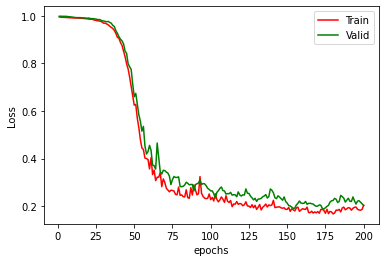

In [ ]:
# plot the variation of train and validation losses vs n_epochs
loss=pd.read_csv('loss_epoch.csv',header=0,index_col=False)
plt.plot(loss['epoch'],loss['Training Loss'],'r',loss['epoch'],loss['Validation Loss'],'g')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(labels=['Train','Valid'])
plt.savefig('loss_epoch.png')

##Load  a trained model

In [ ]:
# load the model that got the minimum validation loss
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Generate predictions

###Visualize and save the inference results

/content/inference.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15,4))


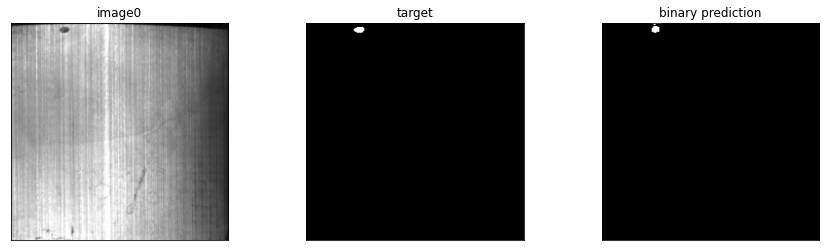

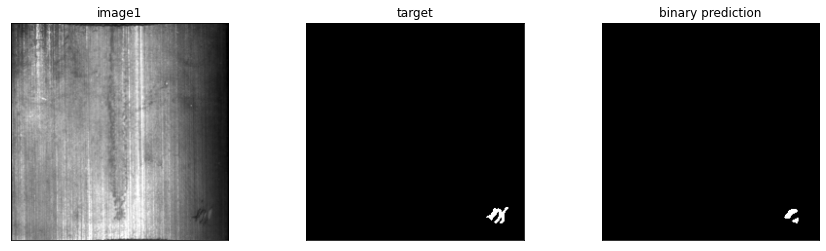

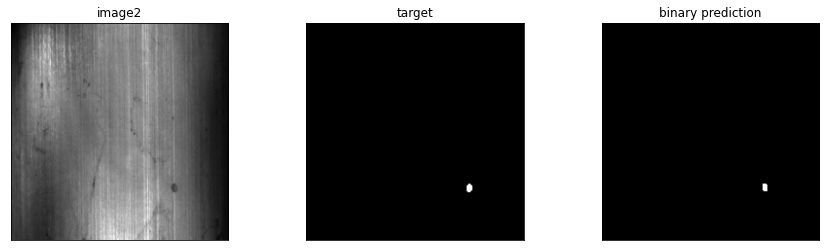

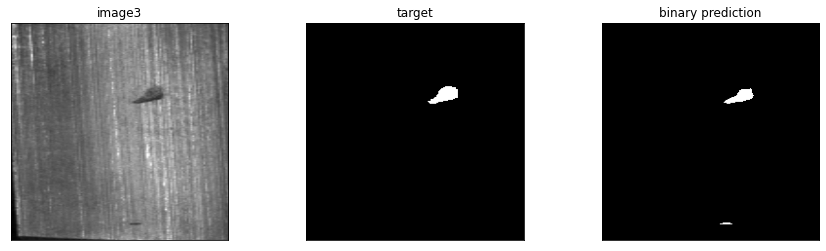

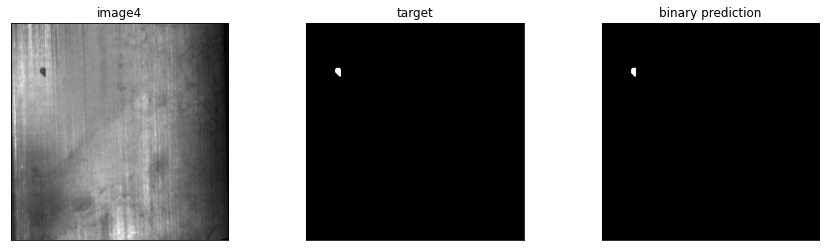

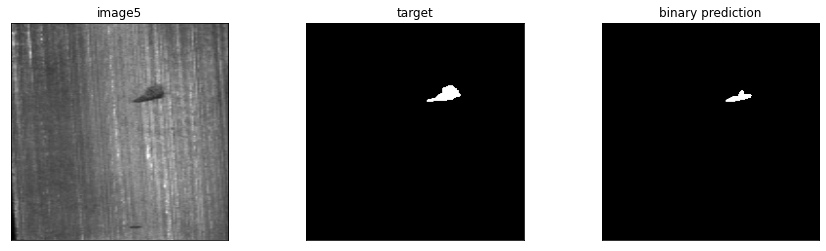

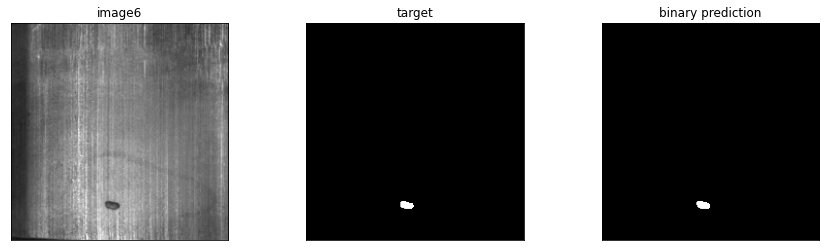

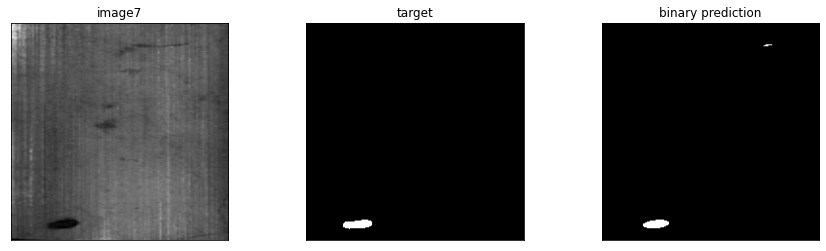

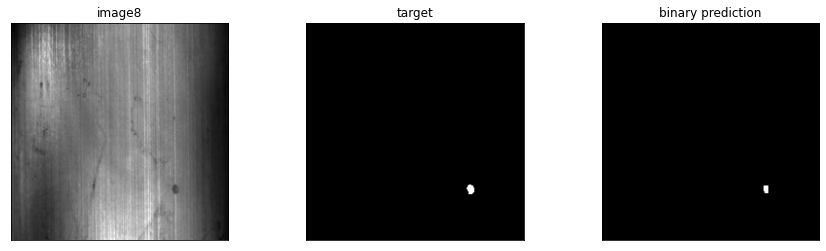

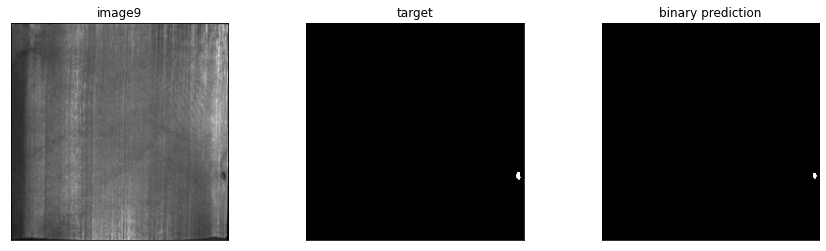

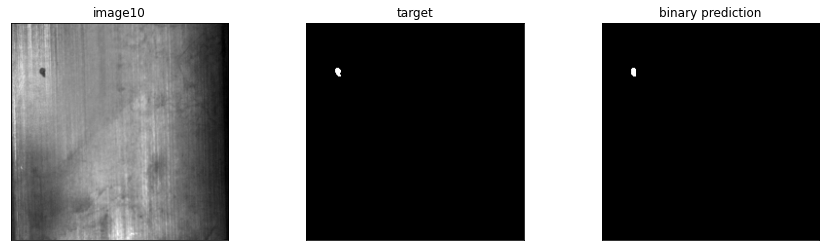

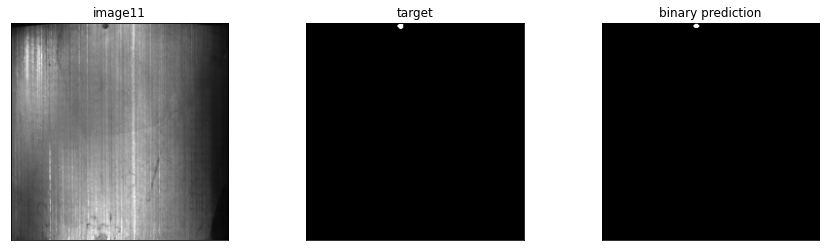

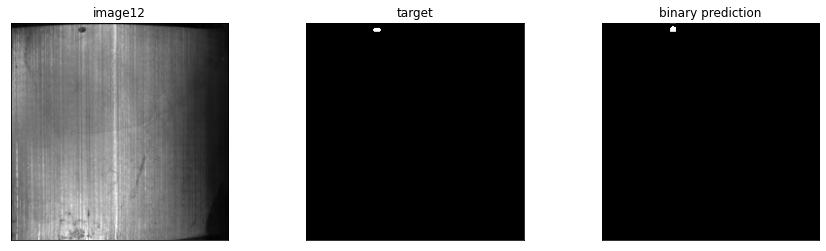

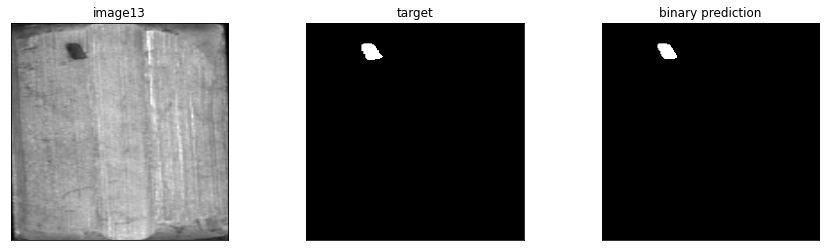

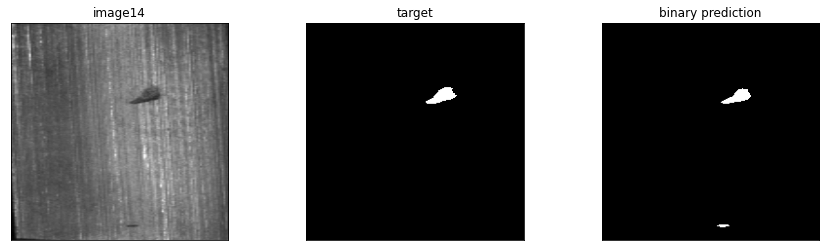

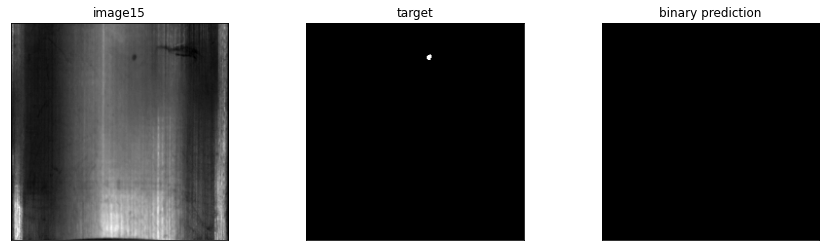

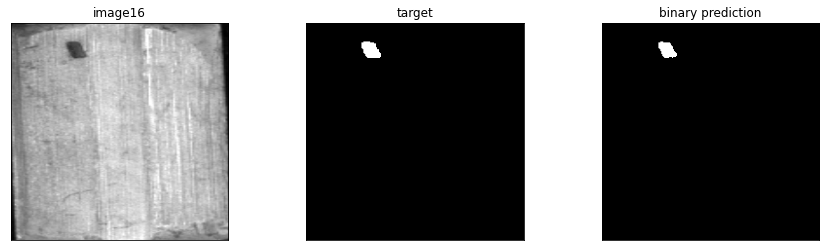

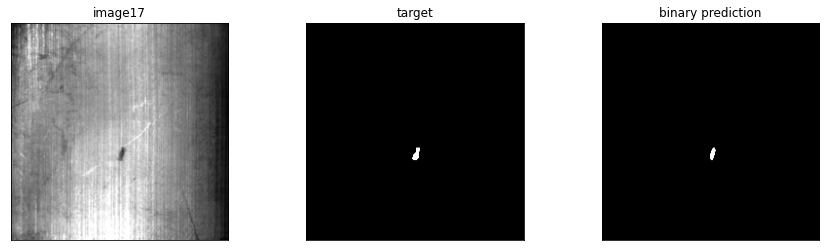

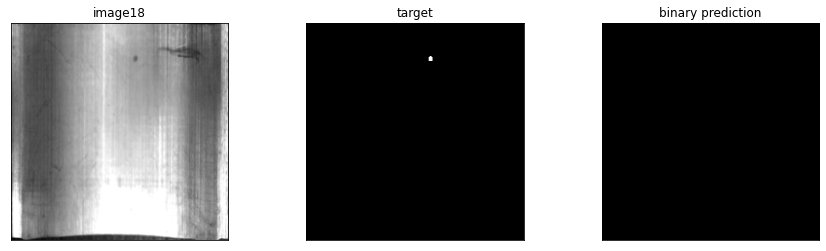

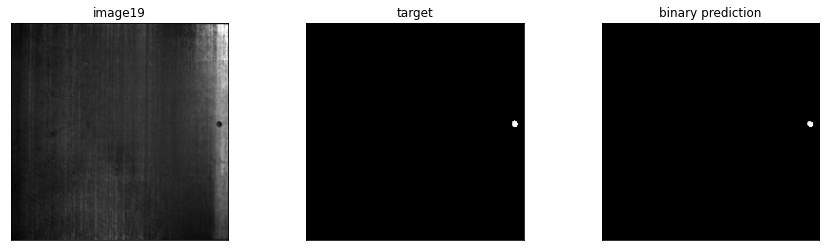

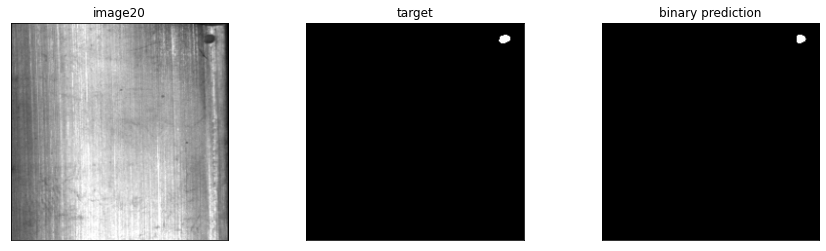

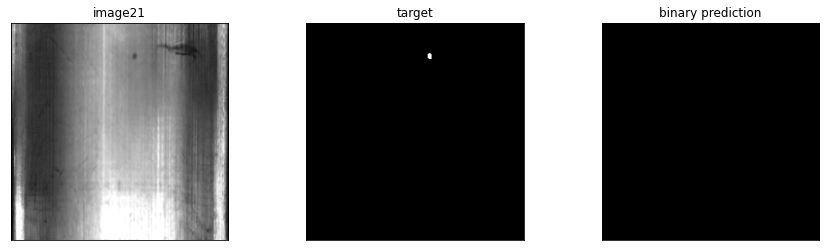

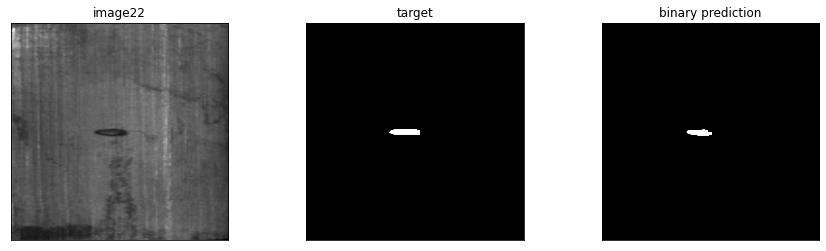

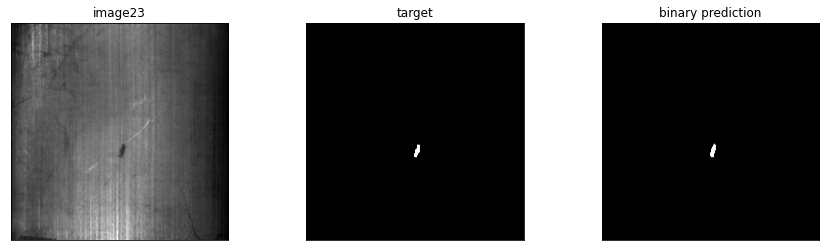

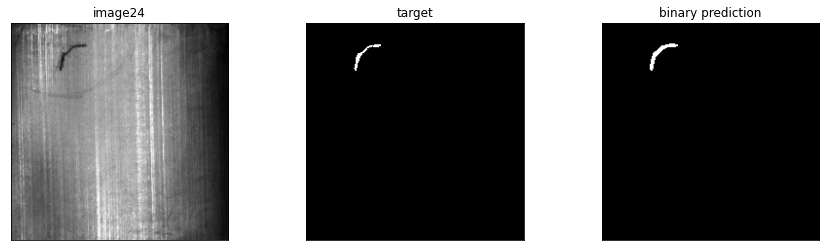

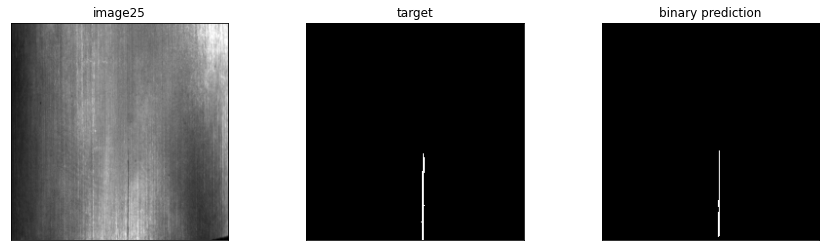

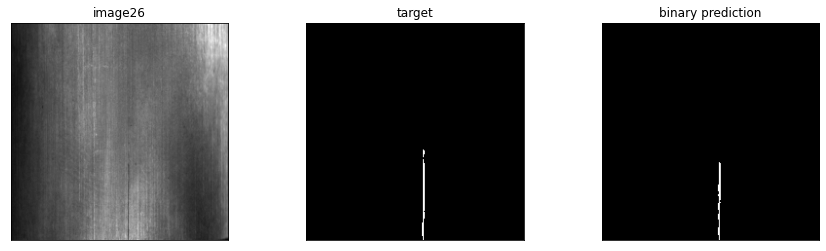

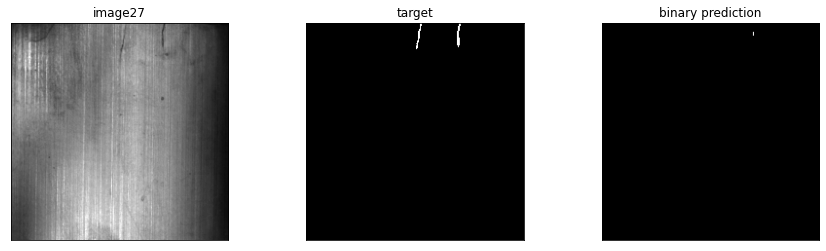

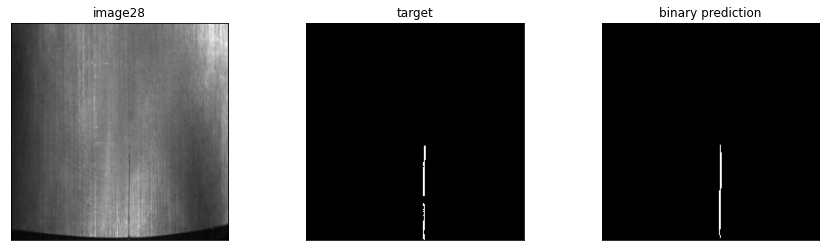

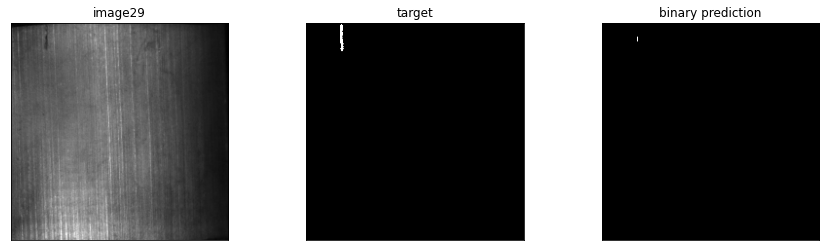

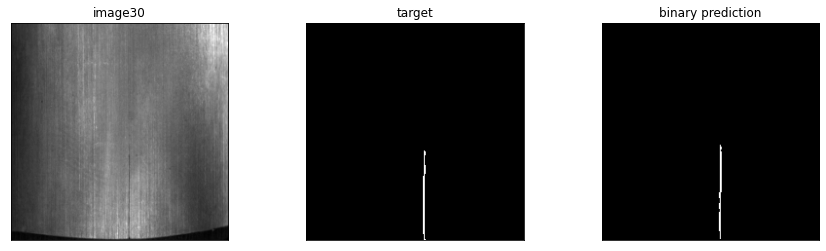

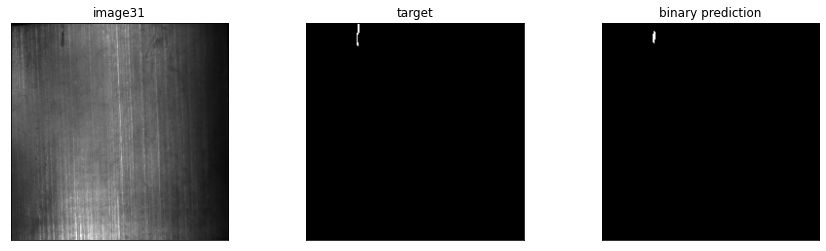

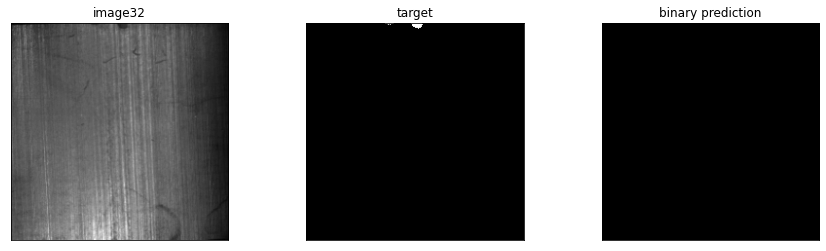

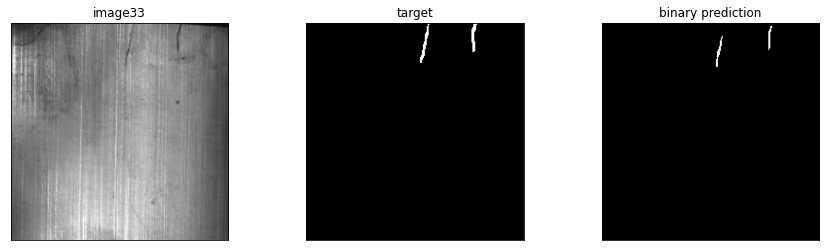

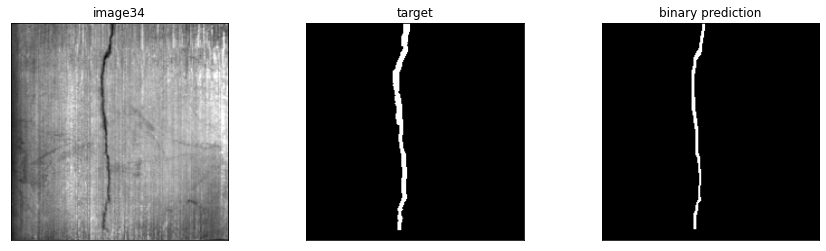

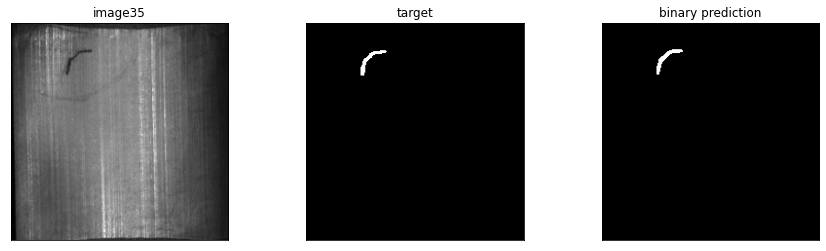

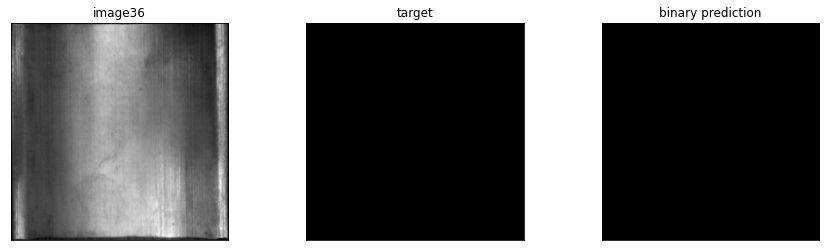

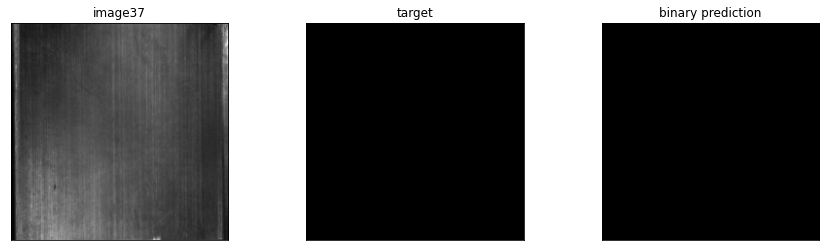

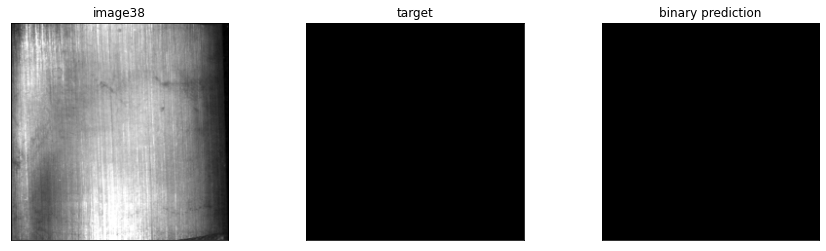

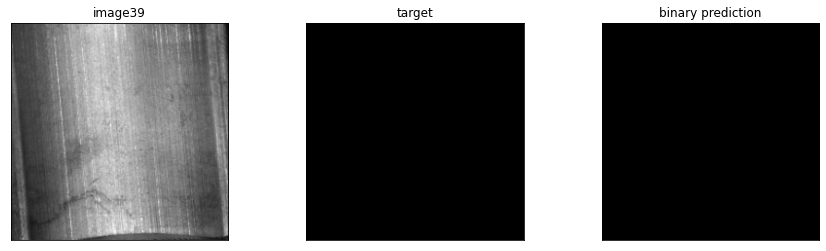

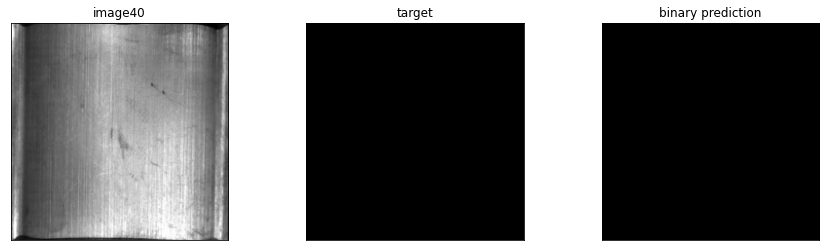

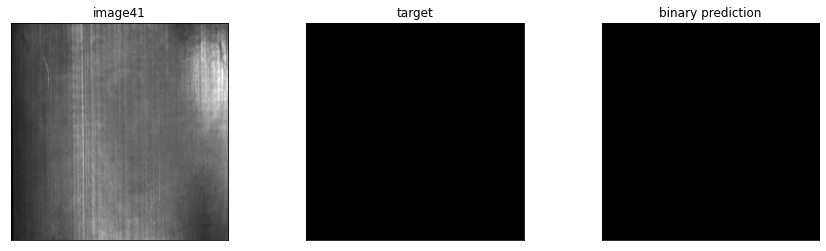

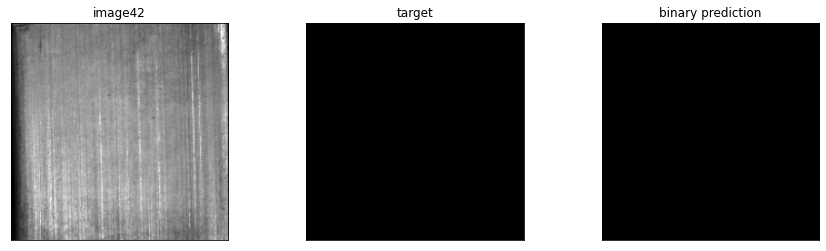

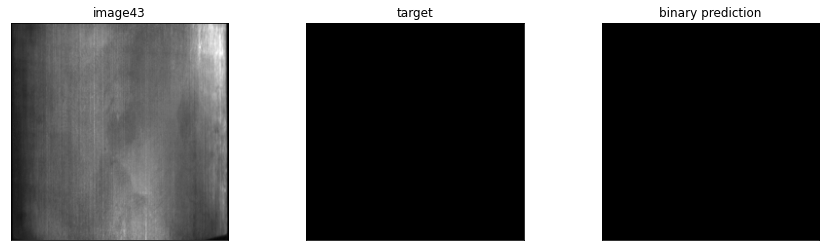

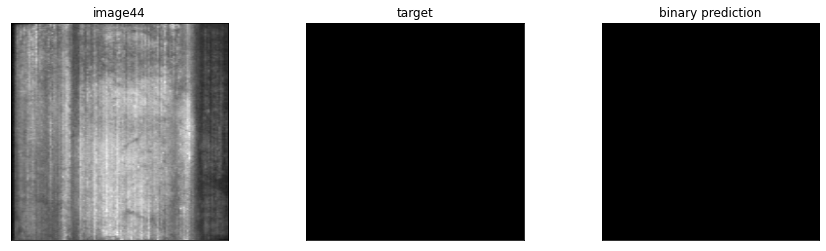

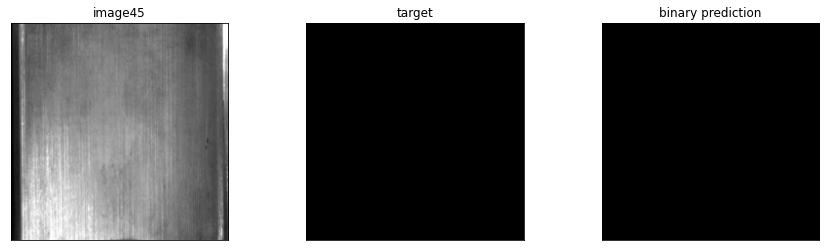

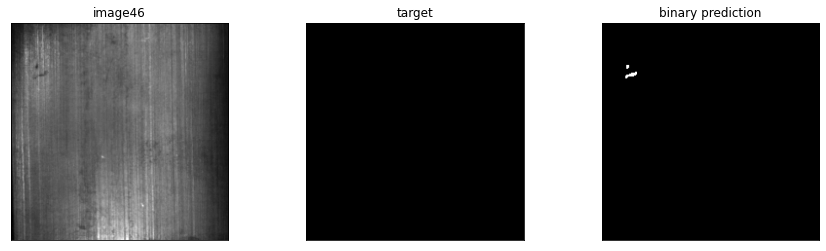

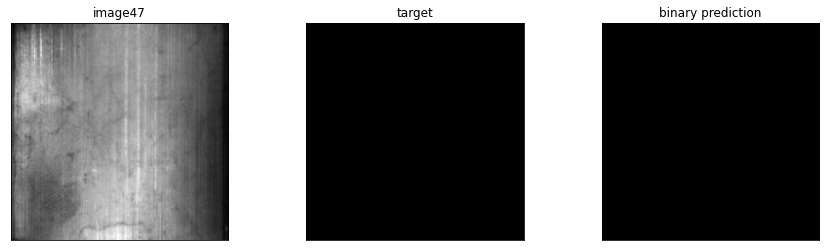

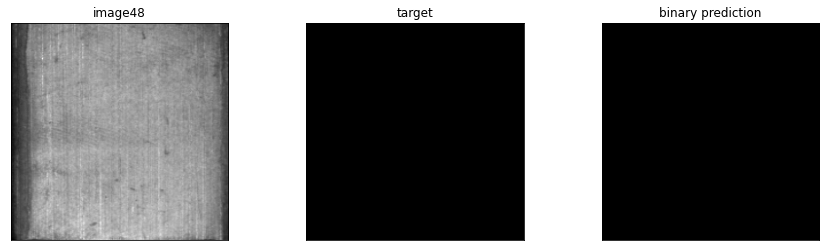

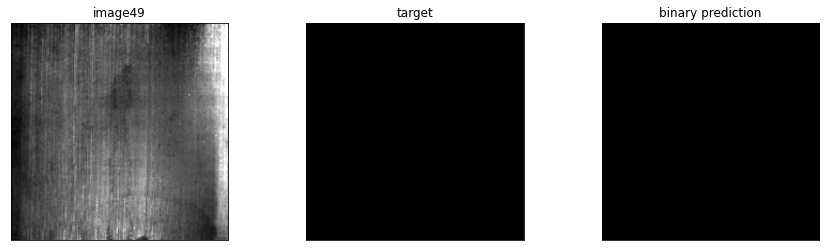

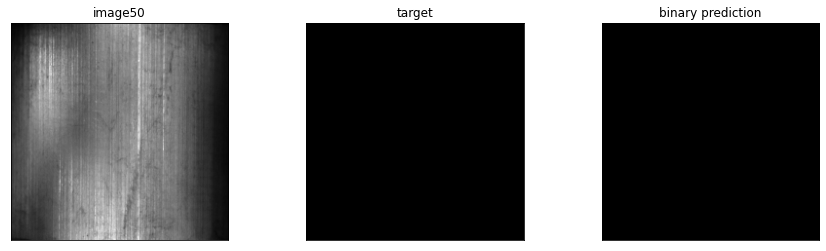

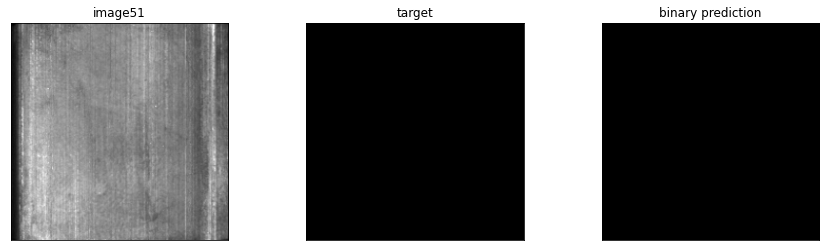

<Figure size 1080x288 with 0 Axes>

In [ ]:
plot_prediction_results(model, train_on_gpu, loaders['test'], threshold)

###Get the inference performance metrics

In [ ]:
df = get_inference_performance_metrics(model, train_on_gpu, loaders['test'], threshold)

In [ ]:
df.describe()

,specificity,sensitivity,precision,F1_score,F2_score,DSC,F_beta,MAE,acc
count,53.000000,5.300000e+01,5.300000e+01,5.300000e+01,5.300000e+01,5.300000e+01,5.300000e+01,5.300000e+01,53.000000
mean,0.085954,5.416411e-02,6.079280e-02,5.554015e-02,5.443839e-02,5.554015e-02,5.741249e-02,8.859893e-05,0.085891
std,0.153997,1.178239e-01,1.088279e-01,1.090928e-01,1.134035e-01,1.090928e-01,1.077724e-01,2.043840e-04,0.153913
min,0.018868,2.538788e-110,2.383985e-110,2.458953e-110,2.506240e-110,2.458953e-110,2.418009e-110,2.072035e-68,0.018868
25%,0.025000,1.699629e-27,1.595994e-27,1.646182e-27,1.677839e-27,1.646182e-27,1.618772e-27,8.758195e-18,0.025000
50%,0.037021,2.362916e-02,2.573529e-02,2.288611e-02,2.332622e-02,2.288610e-02,2.302424e-02,2.562562e-05,0.036993
75%,0.071427,6.071443e-02,5.855736e-02,5.646509e-02,5.917170e-02,5.646509e-02,5.712185e-02,4.871771e-05,0.071385
max,0.999401,7.777778e-01,5.833333e-01,6.666666e-01,7.291667e-01,6.666667e-01,6.190476e-01,1.036360e-03,0.999163


In [ ]:
#!pip install pipreqs
#!pipreqs
